In [3]:
#Mounting google drive 
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
#Installing deeppavlov library
!pip install -q deeppavlov

In [ ]:
#Installing relevant version of tensorflow with gpu access
!pip install tensorflow-gpu==1.15.2

In [ ]:
#Downloading the dependencies required for 'ner_rus_bert' model
!python -m deeppavlov install ner_rus_bert

In [ ]:
#Installing additional library 'pytils' for detranslification of english words into russian
!pip install -q pytils

In [ ]:
#Installing library which measures Levenshtein distance. Will be in use in the code.
!pip install python-Levenshtein

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from re import sub
import re
import tqdm
import pytils.translit
from collections import OrderedDict
import Levenshtein
import itertools
import json
from deeppavlov import configs, build_model, train_model

In [ ]:
#Test of gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#Test of memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(ram_gb)

27.393773568


In [ ]:
#Gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jan  5 16:49:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |    265MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Changing the configuration of the config and the data path
with open(configs.ner.ner_rus_bert, 'r+') as f:
    ner_config = json.load(f)

    ner_config['metadata']['variables']['ROOT_PATH'] = "/drive/My Drive/Colab_Notebooks/deeppavlov_ner/model_data"

    ner_config['chainer']['pipe'][0]['do_lower_case'] = False
    ner_config['chainer']['pipe'][0]['max_seq_length'] = 512 # was 512
    ner_config['chainer']['pipe'][2]['learning_rate_drop_patience'] = 14 # was 30
    ner_config['chainer']['pipe'][2]['learning_rate_drop_div'] = 1.2 # was 1.5
    ner_config['train']['val_every_n_batches'] = 20 # was 20
    ner_config['train']['log_every_n_batches'] = 20
    ner_config['train']['epochs'] = 30 # was 30

    f.seek(0)  # rewind
    json.dump(ner_config, f)
    f.truncate()

In [ ]:
#Downloading and building the model

#ner_model.destroy()
ner_model = build_model(configs.ner.ner_rus_bert, download=True)

Running javascript snippet to continue running the notebook while training

In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
#Training the model
ner_model = train_model(configs.ner.ner_rus_bert)

In [ ]:
#Plotting training graphs

In [5]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

In [10]:
os.chdir('/training_logs')
df_loss = pd.read_csv('loss.csv', sep = ',')

df_loss['Time'] = [(datetime.fromtimestamp(i)).strftime('%H:%M') for i in df_loss['Wall time']]
df_loss['Time'] = pd.to_datetime(df_loss['Time'], format = '%H:%M')

In [15]:
df_loss

,Wall time,Step,Value,Time
0,1.609456e+09,20,38.146557,1900-01-01 02:10:00
1,1.609456e+09,40,18.398954,1900-01-01 02:14:00
2,1.609457e+09,60,15.694152,1900-01-01 02:18:00
3,1.609457e+09,80,12.590878,1900-01-01 02:22:00
4,1.609457e+09,100,11.603771,1900-01-01 02:25:00
...,...,...,...,...
87,1.609475e+09,1760,2.843763,1900-01-01 07:22:00
88,1.609475e+09,1780,2.470375,1900-01-01 07:26:00
89,1.609475e+09,1800,3.145641,1900-01-01 07:29:00
90,1.609476e+09,1820,2.640328,1900-01-01 07:33:00


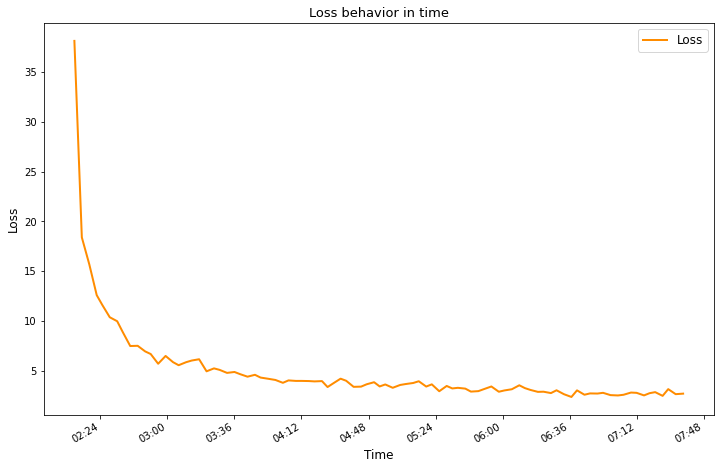

In [16]:
x = df_loss['Time']
y = df_loss['Value']

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x,y, linewidth=2, color = 'darkorange', label = 'Loss')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Loss', fontsize=12)


hour_formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(hour_formatter)
locator = MaxNLocator(nbins=10)
ax.xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.title('Loss behavior in time', fontdict = {'fontsize' : 13})
plt.legend(loc = 1, prop={'size': 12})
plt.show()

In [11]:
df_valid_f1 = pd.read_csv('valid_f1.csv', sep = ',')
df_valid_f1['Time'] = [(datetime.fromtimestamp(i)).strftime('%H:%M') for i in df_valid_f1['Wall time']]
df_valid_f1['Time'] = pd.to_datetime(df_valid_f1['Time'], format = '%H:%M')

df_train_f1 = pd.read_csv('train_f1.csv', sep = ',')
df_train_f1['Time'] = [(datetime.fromtimestamp(i)).strftime('%H:%M') for i in df_valid_f1['Wall time']]
df_train_f1['Time'] = pd.to_datetime(df_train_f1['Time'], format = '%H:%M')

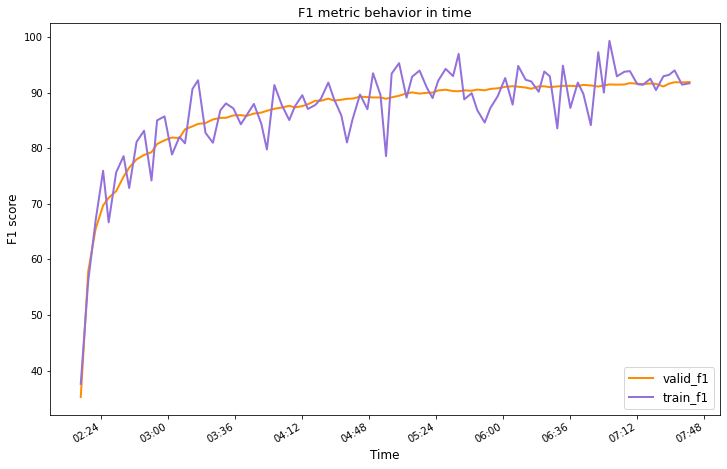

In [14]:
y_valid = df_valid_f1['Value']
y_train = df_train_f1['Value']
x = df_valid_f1['Time']

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x, y_valid, linewidth=2, color = 'darkorange', label = 'valid_f1')
plt.plot(x, y_train, linewidth=2, color = 'mediumpurple', label = 'train_f1')

plt.xlabel('Time', fontsize=12)
plt.ylabel('F1 score', fontsize=12)


hour_formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(hour_formatter)
locator = MaxNLocator(nbins=10)
ax.xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.title('F1 metric behavior in time', fontdict = {'fontsize' : 13})
plt.legend(loc = 4, prop={'size': 12})
plt.show()

In [ ]:
#Data preprocessing for custom model evaluation on 1000 examples
os.chdir('/data')
df_examples = pd.read_excel('instagram_data.xlsx')
df_examples = df_examples[0:1000]



def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, ' ', data)

def replace_str_index(text,index=0,replacement=''):
    return '%s%s%s'%(text[:index],replacement,text[index+1:])


def replace_bad_characters(text):
    '''replace 'й' by original 'й' and 'ё' by original 'ё' (some caracters have len() == 2 instead of  == 1)'''
    text_corrected = []
    for z in text:
        if z == 'й'[1]: 
            text_corrected[-1] = 'й'     
            continue 
        elif z == 'ё'[1]:
            text_corrected[-1] = 'ё'     
            continue
        else:
            text_corrected.append(z)      
    text = ''.join(text_corrected)
    return text

def prepare_sentence(sentence):
    
    text = sentence.lower()
    text = replace_bad_characters(text)
    text = re.sub('[ё]', 'е', text)
    text = re.sub('[ó]', 'о', text)
    
    text_1 = []
    variable = 0
    for z in text:
          
        if z == '"' and variable == 0:
            text_1.append("«")
            variable += 1
            continue
            
        elif z == '"' and variable >= 1:
            text_1.append("»")
            variable += 1
            continue
            
        else:
            text_1.append(z)
    text = ''.join(text_1)
    
    text = re.sub(r'[+\(]?[0-9][0-9 .\-\(\)]{4,15}[0-9]', ' ', text)
    text = re.sub('[^""«»а-яА-ЯA-Za-z0-9ёй ]+', ' ', text)
    text = remove_emojis(text)
    text = pytils.translit.detranslify(text)
    text = sub(r'\s+', ' ', text).strip().lower()
    text = re.sub('[ё]', 'е', text)
    text = re.sub('[ó]', 'о', text)
    
    
    return f'{text}'

prepared_for_ner = df_examples['full_text'].apply(lambda text: prepare_sentence(text))

In [ ]:
prepared_for_ner[2]

'др алладемидова кардиолог терапевт москва научу управлять своим здоровьем и лечиться правильно врач с чувством юмора онлайн курс консультации очно и онлайн директ ватсап москоw руссиан хттпс апи wхацапп cом сенд пхоне'

In [ ]:
#Function used for prediction retrieval 
def predict_():
    
    tags_dict = {k:v for v,k in dict(ner_model['tag_vocab']).items()}
    global predicted_per_org_loc
    predicted_per_org_loc = ([], [], [])

    for text in tqdm.tqdm_notebook(prepared_for_ner[0:], desc = 'Готово'):
        
        
        ##predictions##
        ner_predictions = ner_model([text])
        ##predictions##
        
        text_splitted = ner_predictions[0][0]
        predicted_tags = ner_predictions[1][0]

        ## PER ##
        
        #calculate Levenshtein distance to filter similar words with "ь"
        PER_predicted = list(OrderedDict.fromkeys([i for i,k in zip(text_splitted, predicted_tags) if 'PER' in k]))
        PER_predicted_ = set(PER_predicted)
        words_with_b = {i for i in PER_predicted if 'ь' in i}
        black_list = []
        for i in words_with_b:
            for w in PER_predicted_ - words_with_b:
                if Levenshtein.distance(i, w) <= 2:
                    black_list.append(w)
        PER_predicted = [i for i in PER_predicted if i not in black_list]
        
        #calculate Levenshtein distance to filter similar words with "й"
        PER_predicted_ = set(PER_predicted)
        words_with_b = {i for i in PER_predicted if 'й' in i}
        black_list = []
        for i in words_with_b:
            for w in PER_predicted_ - words_with_b:
                if Levenshtein.distance(i, w) <= 2:
                    black_list.append(w)
        PER_predicted = [i for i in PER_predicted if i not in black_list]

        #calculate Levenshtein distance to filter similar words with "я"
        PER_predicted_ = set(PER_predicted)
        words_with_b = {i for i in PER_predicted if 'я' in i}
        black_list = []
        for i in words_with_b:
            for w in PER_predicted_ - words_with_b:
                if Levenshtein.distance(i, w) <= 2:
                    black_list.append(w)
        PER_predicted = [i for i in PER_predicted if i not in black_list]
        
        #calculate Levenshtein distance to filter similar words with "кх"
        PER_predicted_ = set(PER_predicted)
        words_with_b = {i for i in PER_predicted if 'кх' in i}
        black_list = []
        for i in words_with_b:
            for w in PER_predicted_ - words_with_b:
                if Levenshtein.distance(i, w) <= 2:
                    black_list.append(i) #append i
        PER_predicted = [i for i in PER_predicted if i not in black_list]

        #filer word occurances within other word
        PER_predicted_ = [i.lower() for i in PER_predicted]
        combinations = list(itertools.combinations(PER_predicted_, 2))
        reversed_combinations = [(v,k) for k,v in combinations]
        total_combinations = combinations + reversed_combinations
        total_combinations = [''.join(i) for i in total_combinations]
        PER_predicted = [i.capitalize() for i in PER_predicted_ if i not in total_combinations]
        PER_predicted = [i + '.' if len(i) == 1 else i for i in PER_predicted]
        PER_predicted = ' '.join(PER_predicted)

        ## ORG ##
        ORG_predicted = ' '.join(list(OrderedDict.fromkeys([i.capitalize() for i,k in zip(text_splitted, predicted_tags) if 'ORG' in k])))

        #replacement of the text specific attributes
        replace_text = [('Фгбу', 'ФГБУ'), (' Г ', ' г. '), ('Мц', 'МЦ'), ('Ооо', 'ООО'), (' Им ', ' им. '), ('Гкб', 'ГКБ'), ('Гбуз', 'ГБУЗ')]
        for k,v in replace_text:
            try:
                ORG_predicted = ORG_predicted.replace(k, v)
            except:
                continue
                
        #replacement of the spaces before and after '«»'
        try:
            index_1 = ORG_predicted.index('«')
            ORG_predicted = replace_str_index(ORG_predicted, index_1 + 1, '')
        except:
            pass
        
        try:
            index_1 = ORG_predicted.index('»')
            ORG_predicted = replace_str_index(ORG_predicted, index_1 - 1, '')
        except:
            pass
        
        ## LOC ##
        LOC_predicted = list(OrderedDict.fromkeys([i.capitalize() for i,k in zip(text_splitted, predicted_tags) if 'LOC' in k]))
        
        
        #exctraction and filter of the text starting after https
        start_of_text = [text.split(' ')[0].capitalize()]       
        try:
            if text.split(' ').index('хттпс'):
                https_index = text.split(' ').index('хттпс')
                end_of_text = text.split(' ')[https_index:]
                full_text = [i.capitalize() for i in start_of_text + end_of_text]
                full_text = [i for i in full_text if any([k.isnumeric() for k in i])]
                LOC_predicted = [i for i in LOC_predicted if i not in full_text]
        except:
            LOC_predicted = [i for i in LOC_predicted if i not in start_of_text]  
        
        #exctraction and filter of the text starting after http
        try:
            if text.split(' ').index('хттп'):
                https_index = text.split(' ').index('хттп')
                end_of_text = text.split(' ')[https_index:]
                full_text = [i.capitalize() for i in start_of_text + end_of_text]
                full_text = [i for i in full_text if any([k.isnumeric() for k in i])]
                LOC_predicted = [i for i in LOC_predicted if i not in full_text]
        except:
            LOC_predicted = [i for i in LOC_predicted if i not in start_of_text]  
                
        #replacement of the text specific attributes
        adress_def_point = ['Ул',  'Ш', 'Просп', 'Корп',\
                       'Бул',  'Д', 'Стр', 'К', 'Пр', 'Кт', 'Т', 'Д', 'Г', 'Оф', 'Мкр']
        adress_def_lower = ['Бульвар', 'Улица', 'Шоссе', 'Проезд']
        LOC_predicted_ = []
        LOC_predicted = ' '.join([i.lower() if i in adress_def_lower else i.lower() + '.' if i in adress_def_point else i for i in LOC_predicted])
        
        replace_text = [('Ростов На Дону', 'Ростов-на-Дону'), ('Санкт Петербург', 'Санкт-Петербург')]
        for k,v in replace_text:
            try:
                LOC_predicted = LOC_predicted.replace(k, v)
            except:
                continue

        #append predictions
        predicted_per_org_loc[0].append(PER_predicted)
        predicted_per_org_loc[1].append(ORG_predicted)
        predicted_per_org_loc[2].append(LOC_predicted)



In [ ]:
predict_()

In [ ]:
#Computing metrics on self labaled data (sample of 1000 sentences with 1377 observations)
os.chdir('/data')
df_pavlov = pd.DataFrame( {'Names_pavlov': predicted_per_org_loc[0], 'Organisations_pavlov': predicted_per_org_loc[1], 'Locations_pavlov': predicted_per_org_loc[2]})
df_validation = pd.read_excel('model_validation.xlsx')
df_validation_pavlov = pd.concat([df_validation['full_text'], df_validation['Correct'], df_pavlov], axis=1)

df_validation_pavlov = df_validation_pavlov.fillna('')
df_validation_pavlov['Names_pavlov'] = df_validation_pavlov['Names_pavlov'].apply(lambda x: sub(r'\s+', ' ', sub('[^а-яА-ЯA-Za-z ]+', ' ', x).strip()))
df_validation_pavlov['Correct'] = df_validation_pavlov['Correct'].apply(lambda x: sub(r'\s+', ' ', sub('[^а-яА-ЯA-Za-z ]+', ' ', x).strip()))

df_validation_pavlov['Names_pavlov'] = df_validation_pavlov['Names_pavlov'].apply(lambda x: set(x.split(' ')))
df_validation_pavlov['Correct'] = df_validation_pavlov['Correct'].apply(lambda x: set(x.split(' ')))

#total observations
all_observations = sum([0 if df_validation_pavlov['Correct'][i] == {''} else len(df_validation_pavlov['Correct'][i]) for i in range(1000)])

#deeppavlov NER model
true_positives = sum([0 if all([df_validation_pavlov['Names_pavlov'][i] == {''}, df_validation_pavlov['Correct'][i] == {''}]) else len(df_validation_pavlov['Correct'][i] & df_validation_pavlov['Names_pavlov'][i]) for i in range(1000)])
false_positives = sum([0 if df_validation_pavlov['Names_pavlov'][i] - df_validation_pavlov['Correct'][i] == {''} else len(df_validation_pavlov['Names_pavlov'][i] - df_validation_pavlov['Correct'][i]) for i in range(1000)])
false_negatives = sum([0 if df_validation_pavlov['Correct'][i] - df_validation_pavlov['Names_pavlov'][i] == {''} else len(df_validation_pavlov['Correct'][i] - df_validation_pavlov['Names_pavlov'][i]) for i in range(1000)])

accuracy = true_positives / all_observations
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * precision * recall / (recall + precision)

accuracy_f1_harmonic_mean = 2 * accuracy * f1_score / (accuracy + f1_score)

print('Total Observations: ', all_observations)
print('TP: ', true_positives)
print('FP: ', false_positives)
print('FN: ', false_negatives)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('accuracy_f1_harmonic_mean: ', accuracy_f1_harmonic_mean)
print('f1_score: ', f1_score)


Total Observations:  1377
TP:  1224
FP:  107
FN:  153
Accuracy:  0.8888888888888888
Precision:  0.9196093163035312
Recall:  0.8888888888888888
accuracy_f1_harmonic_mean:  0.89637495422922
f1_score:  0.9039881831610043


We can see that f1_score is 0.9039 which is quite good.